In [1]:
import numpy as np # array operations
import cv2 # opencv library read img operations
import matplotlib.pyplot as plt # show img 
from scipy.linalg import solve # slove Ax=b
import scipy.spatial.distance as dis
import math

In [2]:
# 取自 https://stackoverflow.com/questions/38285229/calculating-aspect-ratio-of-perspective-transform-destination-image
def  realAspect_W_H(in_rgb, in_x, in_y):
    #image center
    cols=in_rgb.shape[1]
    rows=in_rgb.shape[0]
    u0 = (cols)/2.0
    v0 = (rows)/2.0
    
    # 計算歐式距離
    w1=dis.euclidean([in_x[0],in_y[0]],[in_x[1],in_y[1]])
    w2=dis.euclidean([in_x[2],in_y[2]],[in_x[3],in_y[3]])
    w=max(w1,w2)

    h1=dis.euclidean([in_x[2],in_y[2]],[in_x[0],in_y[0]])
    h2=dis.euclidean([in_x[3],in_y[3]],[in_x[1],in_y[1]])
    h=max(h1,h2)
    
    #visible aspect ratio
    ar_vis = float(w)/float(h)
    
    #make numpy arrays and append 1 for linear algebra
    m1 = np.array((in_x[0],in_y[0],1)).astype('float32')
    m2 = np.array((in_x[1],in_y[1],1)).astype('float32')
    m3 = np.array((in_x[2],in_y[2],1)).astype('float32')
    m4 = np.array((in_x[3],in_y[3],1)).astype('float32')

    #calculate the focal disrance 焦距
    k2 = np.dot(np.cross(m1,m4),m3) / np.dot(np.cross(m2,m4),m3)
    k3 = np.dot(np.cross(m1,m4),m2) / np.dot(np.cross(m3,m4),m2)

    n2 = k2 * m2 - m1
    n3 = k3 * m3 - m1

    n21 = n2[0]
    n22 = n2[1]
    n23 = n2[2]

    n31 = n3[0]
    n32 = n3[1]
    n33 = n3[2]

    f = math.sqrt(np.abs( (1.0/(n23*n33)) * ((n21*n31 - (n21*n33 + n23*n31)*u0 + n23*n33*u0*u0) + (n22*n32 - (n22*n33+n23*n32)*v0 + n23*n33*v0*v0))))

    R = np.array([[f,0,u0],[0,f,v0],[0,0,1]]).astype('float32')

    Rt = np.transpose(R)
    Rti = np.linalg.inv(Rt)
    Ri = np.linalg.inv(R)

    # calculate the real aspect ratio
    ar_real = math.sqrt(np.dot(np.dot(np.dot(n2,Rti),Ri),n2)/np.dot(np.dot(np.dot(n3,Rti),Ri),n3))

    if ar_real < ar_vis:
        W = int(w)
        H = int(W / ar_real)
    else:
        H = int(h)
        W = int(ar_real * H)
    return W,H

In [3]:
def invert_mapping(X, input_img, output_img):
    rows = output_img.shape[0]
    cols = output_img.shape[1]

    for i in range(rows):
        for j in range(cols):
            # 新座標點
            double_x = (X[0] * i) + (X[1] * j) + (X[2] * i * j) + X[3]
            double_y = (X[4] * i) + (X[5] * j) + (X[6] * i * j) + X[7]
            
            # 距離新座標點最近的整數點
            x = int(double_x)
            y = int(double_y)
            
            # a:y軸距離(x座標差) b:x軸距離(y座標差)
            a = (double_x - x)
            b = (double_y - y)
            
            # 做 bilinear interpolation 雙線性插值
            # 圖是(row,col)即 (y,x)
            for c in range(3):
                output_img[i, j, c] = (1 - a) * (1 - b) * input_img[y, x, c] + \
                                      a * (1 - b) * input_img[y, x+1, c] + \
                                      (1 - a) * b * input_img[y+1, x, c] + \
                                      a * b * input_img[y + 1, x + 1, c]
    return output_img

(1478, 1108, 3)
w 976 h 1405
A [[      0       0       0       1       0       0       0       0]
 [      0     976       0       1       0       0       0       0]
 [   1405       0       0       1       0       0       0       0]
 [   1405     976 1371280       1       0       0       0       0]
 [      0       0       0       0       0       0       0       1]
 [      0       0       0       0       0     976       0       1]
 [      0       0       0       0    1405       0       0       1]
 [      0       0       0       0    1405     976 1371280       1]]
x[0]=-0.06405693950177936
x[1]=0.5635245901639344
x[2]=0.0003062831806779068
x[3]=220.0
x[4]=0.6227758007117438
x[5]=-0.015368852459016393
x[6]=-6.92783384866694e-05
x[7]=490.0


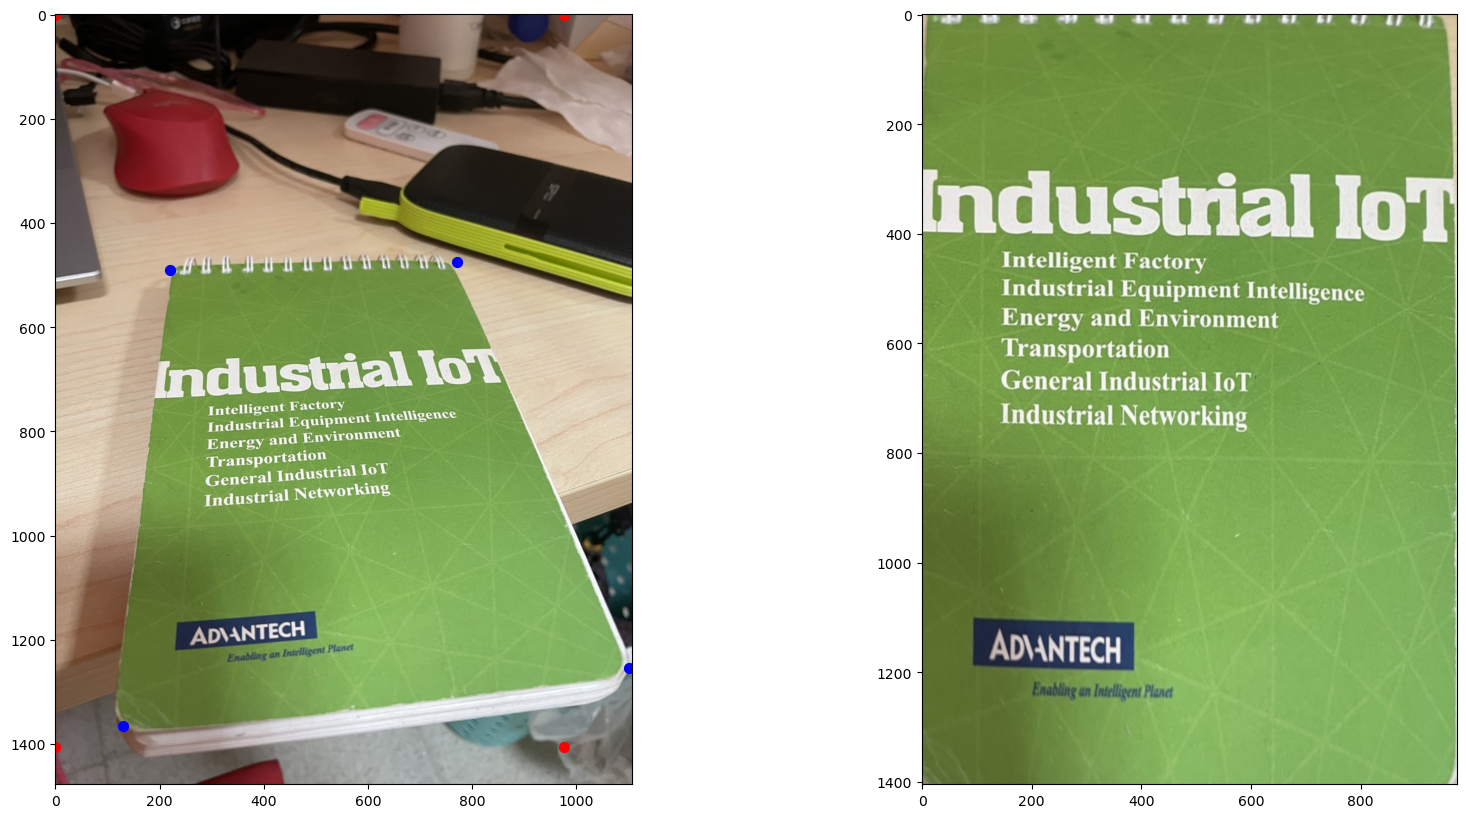

In [4]:
# 讀圖 opencv 讀進為 BGR 需轉換 成 RBG
in_bgr = cv2.imread('notebook.jpg',cv2.IMREAD_COLOR)
# 轉 BGR >> RGB
in_rgb = cv2.cvtColor(in_bgr,cv2.COLOR_BGR2RGB)
print(in_rgb.shape)

# 用小畫家找4點像素座標
in_x=[220, 770, 130, 1100]
in_y=[490, 475, 1365, 1255]

# 計算新圖正確 width and height
w,h=realAspect_W_H(in_rgb, in_x, in_y)
print("w",w,"h",h)

# 新圖4點座標
out_x=[0, w, 0, w]
out_y=[0, 0, h, h]
# 建 ndarray轉換圖大小
out_rgb = np.ndarray((h,w,3), dtype=np.uint8)

# 顯示圖片
plt.figure(figsize=(20,10))

# 印出圖片 畫出原圖4個點(藍) 和 轉換後的4點位置(紅)
plt.subplot(121)
plt.imshow(in_rgb)
plt.scatter(in_x[0], in_y[0], s=50 ,c='b')
plt.scatter(in_x[1], in_y[1], s=50, c='b')
plt.scatter(in_x[2], in_y[2], s=50, c='b')
plt.scatter(in_x[3], in_y[3], s=50, c='b')

plt.scatter(0, 0, s=50, c='r')
plt.scatter(w, 0, s=50, c='r')
plt.scatter(0, h, s=50, c='r')
plt.scatter(w, h, s=50, c='r')

# 圖是(row,col) 即 (y,x) 故先 y 後 x 去做計算
A=np.array([
    [out_y[0] , out_x[0], out_x[0]*out_y[0], 1, 0, 0, 0, 0],
    [out_y[1] , out_x[1], out_x[1]*out_y[1], 1, 0, 0, 0, 0],
    [out_y[2] , out_x[2], out_x[2]*out_y[2], 1, 0, 0, 0, 0],
    [out_y[3] , out_x[3], out_x[3]*out_y[3], 1, 0, 0, 0, 0],
    [0, 0, 0, 0, out_y[0] , out_x[0], out_x[0]*out_y[0], 1],
    [0, 0, 0, 0, out_y[1] , out_x[1], out_x[1]*out_y[1], 1],
    [0, 0, 0, 0, out_y[2] , out_x[2], out_x[2]*out_y[2], 1],
    [0, 0, 0, 0, out_y[3] , out_x[3], out_x[3]*out_y[3], 1],
])
print("A",A)

b=np.array([in_x[0], in_x[1], in_x[2], in_x[3], in_y[0], in_y[1], in_y[2], in_y[3]])
X = solve(A, b)
[print(f'x[{i}]={X[i]}') for i in range(8)]

# 做 inverse mapping + bilinear interpolation 雙線性插值
output_img=invert_mapping(X, in_rgb, out_rgb)

# show 出轉換後結果
plt.subplot(122)
plt.imshow(out_rgb)